### import necessary modules
<ul>
<li> nltk library packs all the text formatting options </li>
<li> RegexpParser converts the given input into a parse Tree structure following grammar rules in the form of regular expressions.</li>
<li> Tree is a class, that is returned by RegexpParser.</li>
<li> Spacy is a python framework used for Named Entity recognition.</li>
</ul>

In [1]:
import nltk
from nltk.tree import Tree
from nltk.chunk import RegexpParser
import spacy

### Spacy NER model should be loaded before using it.

In [2]:
nlp=spacy.load(r'en_core_web_sm')

###  Each segment is tokenized and tagged by NLTK POS Tagger 
<ol>
<li> Break down the whole sentence into small sentences to preserve the context. </li>
<li> tokenize each sub sentence into list of words </li>
<li> obtain the parts of speech tags for each word in the list.</li>
</ol>

In [3]:
def ie_preprocess(segment):
        sentences = nltk.sent_tokenize(segment) 
        prepared_sents=[]
        for sent in sentences:
            prepared_sents=prepared_sents+nltk.word_tokenize(sent)
        words_list=[]
        for sent in prepared_sents:
            words_list=words_list+nltk.word_tokenize(sent)
        tagged_words = nltk.pos_tag(words_list)
        return tagged_words

### POS tags used in NLTK

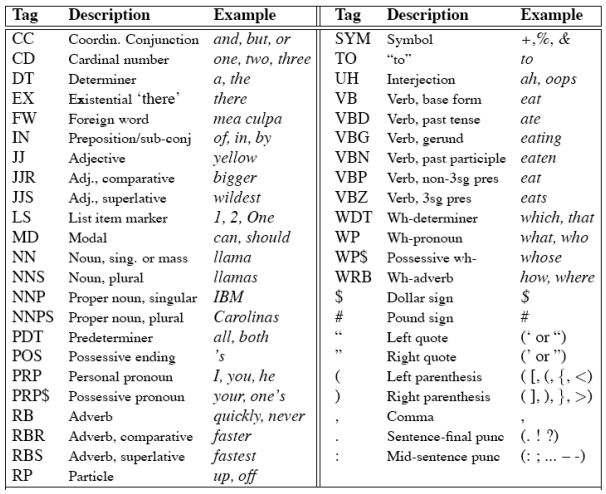

In [4]:
from IPython.display import Image
Image(filename='pos.JPG')

### Clause Identification
<p>Operators in Regular expresssions</p>
<ul>
    <li> ? zero or one</li>
    <li> . (dot) represents wildcard- represents any one character</li>
    <li> * zero or more </li>
    <li> + one or more </li>
    </ul>
<p>For demonstration purpose let's assume a sample sentence and grammer.</p>
<p><b>NP means a Noun Phrase</b>, which is a chunk of sentence starting with determiner (zero or one), followed by any kind of adjective (zero or more) and that followed by zero or more prepositions,determiners,conjunctions, past participle verbs with atleast one of the noun forms (or pronouns,posessive or personal pronouns or a gerund,verb that looks like a noun)</p>
<p>Similarly a regular expression rule representing grammar for <b> verb phrase -VP</b> is written</p>
<p>The segment that contains a <b>noun phrase</b> followed by a <b>verb phrase</b> is treated as a <b> CLAUSE</b></p>



In [5]:
grammar=r'''
            NP:{<DT>?<JJ.?>*(<IN|DT|CC|VBN>*<NN.?|PRP|PRP$|POS|VBG>+)+} 
            VP:{<RB.?|VB.?|MD|RP>+}
            CLAUSE:{<NP>+<VP>+} 
    '''

sentence=""" Deputy Chief Minister and Services Department Minister-in-charge
Manish Sisodia ordered the Department to change the approving authority"""

#### Look at the POS tags in above sentence by calling preprocess function
#### Expected Output:
[('Deputy', 'NNP'), ('Chief', 'NNP'), ('Minister', 'NNP'), ('and', 'CC'), ('Services', 'NNP'), ('Department', 'NNP'), ('Minister-in-charge', 'NNP'), ('Manish', 'NNP'), ('Sisodia', 'NNP'), ('ordered', 'VBD'), ('the', 'DT'), ('Department', 'NNP'), ('to', 'TO'), ('change', 'VB'), ('the', 'DT'), ('approving', 'NN'), ('authority', 'NN')]

In [6]:
pos_tags=ie_preprocess(sentence)
print(pos_tags)

[('Deputy', 'NNP'), ('Chief', 'NNP'), ('Minister', 'NNP'), ('and', 'CC'), ('Services', 'NNP'), ('Department', 'NNP'), ('Minister-in-charge', 'NNP'), ('Manish', 'NNP'), ('Sisodia', 'NNP'), ('ordered', 'VBD'), ('the', 'DT'), ('Department', 'NNP'), ('to', 'TO'), ('change', 'VB'), ('the', 'DT'), ('approving', 'NN'), ('authority', 'NN')]


####  These list of tuples are processed further to check for grammar and obtain a parse tree 
<ol>
<li> create a chunk parser using the predefined grammar</li>
<li> parse the list of tuples and obtain parse_tree </li>
</ol>

In [7]:
def parse_chunks(tagged_segments, grammar):
        cp = RegexpParser(grammar)
        tree = cp.parse(tagged_segments)
        return tree

#### Parse and check the output
#### Expected output:
Tree('S', [Tree('CLAUSE', [Tree('NP', [('Deputy', 'NNP'), ('Chief', 'NNP'), ('Minister', 'NNP'), ('and', 'CC'), ('Services', 'NNP'), ('Department', 'NNP'), ('Minister-in-charge', 'NNP'), ('Manish', 'NNP'), ('Sisodia', 'NNP')]), Tree('VP', [('ordered', 'VBD')])]), Tree('NP', [('the', 'DT'), ('Department', 'NNP')]), ('to', 'TO'), Tree('VP', [('change', 'VB')]), Tree('NP', [('the', 'DT'), ('approving', 'NN'), ('authority', 'NN')])])



In [8]:
parse_tree=parse_chunks(pos_tags,grammar)
print(parse_tree)

(S
  (CLAUSE
    (NP
      Deputy/NNP
      Chief/NNP
      Minister/NNP
      and/CC
      Services/NNP
      Department/NNP
      Minister-in-charge/NNP
      Manish/NNP
      Sisodia/NNP)
    (VP ordered/VBD))
  (NP the/DT Department/NNP)
  to/TO
  (VP change/VB)
  (NP the/DT approving/NN authority/NN))


####  Check for clauses and extract any, if found
<p>Traverse through each sub-tree, see if its label matches with any of those present in chunks_list and return them in a list

In [9]:
def find_chunk(chunks,chunks_list=['CLAUSE']):
    return [subtree for subtree in chunks.subtrees(filter = lambda t: t.label() in chunks_list)]
# [i for i in range(0,10)]

#### From the above parse_tree, the identified_chunk could be:
<p>Deputy Chief Minister and Services Department Minister-in-charge Manish Sisodia ordered</p>

In [10]:
find_chunk(parse_tree)

[Tree('CLAUSE', [Tree('NP', [('Deputy', 'NNP'), ('Chief', 'NNP'), ('Minister', 'NNP'), ('and', 'CC'), ('Services', 'NNP'), ('Department', 'NNP'), ('Minister-in-charge', 'NNP'), ('Manish', 'NNP'), ('Sisodia', 'NNP')]), Tree('VP', [('ordered', 'VBD')])])]

### A function to check if the parse_tree has atleast one valid clause

In [11]:
def is_clause(parse_trees): 
    return any([subtree.label()=='CLAUSE' for subtree in find_chunk(parse_trees)])

is_clause(parse_tree)

True

### A function to check if the parse_tree does not have a clause but atleast one verb_phrase

In [12]:
def is_only_VP(parse_tree):
    if is_clause(parse_tree):
        return False
    return any([Tree.fromstring(str(subtree)).label() == 'VP' for subtree in parse_tree])

is_only_VP(parse_tree)

False


### A function to retreive the verb_phrase tree, verb_phrase, front index and rear index from the parse_tree, 
<ul>
    <li>Each child is travered, if the child is a leaf(a tuple), it is skipped after incrementing f_index (front index)</li>
    <li>If the child is a subtree, its label is inspected and processed further.</li>
    <li>If the child is a CLAUSE, it is sure that there are two subtrees under it</li>
    <li>If the subtree under clause is VP, r_index (rear index) is initialised to f_index, text part under each leaf of the subtree is added to obtain final verb phrase, incrementing the r-index </li>
    <li>If it is not a VP, every word is checked while incrementing the f_index</li>
    <li>If subtree of parse_tree itself is a VP or NP, the above process above is repeated.</li>
    </ul>
returns (Verb_phrase_tree  , Verb_phrase  , front index ,  rear index)

In [13]:
def find_VP_tree(parse_tree):
    words=""
    f_index=0
    for child in parse_tree:
            if not isinstance(child,tuple):
                if child.label() == "CLAUSE":
                    for phrase in child:
                        if not isinstance(phrase,tuple):
                            if phrase.label()=="VP":
                                r_index=f_index
                                for word in phrase:
                                    words=words+" "+word[0]
                                    r_index+=1
                                return (phrase,words,f_index,r_index)
                            else:
                                for word in phrase:
                                    f_index+=1
                        else:
                            f_index+=1
                elif child.label()=="VP":
                    r_index=f_index
                    for i in child:
                        words=words+" "+i[0]
                        r_index+=1
                    return (child,words,f_index,r_index)
                else:
                    for word in child:
                        f_index+=1
            else:
                f_index+=1

find_VP_tree(find_chunk(parse_tree)[0])                

(Tree('VP', [('ordered', 'VBD')]), ' ordered', 9, 10)

### A function to retreive the Noun_phrase tree, Noun_phrase, front index and rear index from the parse_tree,
<p>Very similar to what we discussed above except the labels checked are, for NP</p>
returns (Noun_phrase_tree  , Noun_phrase  , front index ,  rear index)

In [14]:
def find_NP_tree(parse_tree):
    words=""
    f_index=0
    for child in parse_tree:
            if not isinstance(child,tuple):
                if child.label() == "CLAUSE":
                    for phrase in child:
                        if phrase.label()=="NP":
                            r_index=f_index
                            for word in phrase:
                                words=words+" "+word[0]
                                r_index+=1
                            return (phrase,words,f_index,r_index)
                        else:
                            for word in phrase:
                                f_index+=1
                elif child.label()=="NP":
                    r_index=f_index
                    for i in child:
                        words=words+" "+i[0]
                        r_index+=1
                    return (child,words,f_index,r_index)
                else:
                    for word in child:
                        f_index+=1
            else:
                f_index+=1
                
find_NP_tree(find_chunk(parse_tree)[0])

(Tree('NP', [('Deputy', 'NNP'), ('Chief', 'NNP'), ('Minister', 'NNP'), ('and', 'CC'), ('Services', 'NNP'), ('Department', 'NNP'), ('Minister-in-charge', 'NNP'), ('Manish', 'NNP'), ('Sisodia', 'NNP')]),
 ' Deputy Chief Minister and Services Department Minister-in-charge Manish Sisodia',
 0,
 9)

### A Generalized function to retreive the phrase tree, phrase_text, front index and rear index of any entity from the parse_tree,
<p>Very similar to what we discussed above except the labels checked are, for POS string</p>

In [15]:
def find_POS_subtree(parse_tree,POS):
    words=""
    f_index=0
    for child in parse_tree:
            if not isinstance(child,tuple):
                if child.label() == "CLAUSE":
                    for phrase in child:
                        if not isinstance(phrase,tuple):
                            if phrase.label()==POS:
                                r_index=f_index
                                for word in phrase:
                                    words=words+" "+word[0]
                                    r_index+=1
                                return (phrase,words,f_index,r_index)
                            else:
                                for word in phrase:
                                    f_index+=1
                        else:
                            f_index+=1
                elif child.label()==POS:
                    r_index=f_index
                    for i in child:
                        words=words+" "+i[0]
                        r_index+=1
                    return (child,words,f_index,r_index)
                else:
                    for word in child:
                        f_index+=1
            else:
                f_index+=1
                
find_POS_subtree(find_chunk(parse_tree)[0],"NP")

(Tree('NP', [('Deputy', 'NNP'), ('Chief', 'NNP'), ('Minister', 'NNP'), ('and', 'CC'), ('Services', 'NNP'), ('Department', 'NNP'), ('Minister-in-charge', 'NNP'), ('Manish', 'NNP'), ('Sisodia', 'NNP')]),
 ' Deputy Chief Minister and Services Department Minister-in-charge Manish Sisodia',
 0,
 9)

### A function to obtain POS phrase from left neighbouring parsetree 
<p>If a parse tree does not have any Noun(subject) phrase accompanying it's verb phrase, it searches for nearest one in neighbouring parse_trees </p>
<ul>
    <li>A list of parse_trees are passed to the function</li>
    <li>Each parse_tree is checked if it has VP alone.</li>
    <li>If the parse_tree has a CLAUSE, it is skipped by appending nothing to return list</li>
    <li>The search for nearest entity begins from the left most neighbour to the first segment's parse tree </li>
    <li>Each parse_tree is checked for Noun_phrase, if found are appended to the return list</li>
    <li>If no Noun phrase is found till the end, None is appended to return list</li>
    </ul>
    
<b>Example:<p></b> <b><i> ”Following his horse-riding interests, Mark enlisted
in 1915 in the Yeomanry, was sent to the front in France in
early 1916.”</i></b></p>
<p>In the sentence, the segment,<b><i>”Following his horse-riding
interests”</i></b> is not a clause but the other segment,<b><i>”Mark enlisted
in 1915 in the Yeomanry”</i></b> has one <b>CLAUSE</b> i.e. <b><i>”Mark enlisted”</i></b></p>
<p>But the next segment starts with a verb_phrase <b><i>"was sent to..."</i></b> has verb phrase <b><i>"was sent to..."</i></b>, after enrichment the sentence will be <b><i>" Mark was sent to..."</i></b></p>
    
  

In [16]:
def find_the_closest_NP_for_VP(parse_trees,POS):
    is_VP =[ is_only_VP(parse_tree) for parse_tree in parse_trees]
    closest_POS = []
    for index,truth_val in enumerate(is_VP):
        if not truth_val:
            closest_POS.append(None)
        else:
            found_POS = False
            for index_tree in reversed(range(0,index)):
                POS,_,_,_=find_POS_subtree(parse_trees[index_tree],POS)
                closest_POS.append(POS)
                found_POS=True
                break
            if not found_POS :
                closest_POS.append(None)
    return closest_POS


### Obtaining Noun phrases alone is not enough, they should be attached to verb phrase in the corresponding parse tree, this may be called as text enrichment
<ul>
    <li><b>Enrichment data :</b>A list of missing Noun phrases are obtained </li>
    <li>for every parse_tree, if enrichment is necessary</li>
    <li>The lonely verb_phrase subtree in that parse_tree is obtained</li>
    <li>The <b>noun_phrase_tree</b>  in the enrichment data is attached to verb_phrase, a <b>CLAUSE subtree</b> is created</li>
    <li>That <b> CLAUSE subtree</b> is inserted into parse_tree in the position of <b>verb_phrase_tree</b></li>
    <li>The redundant and lonely verb_phrase subtree in the parse_tree is removed</li>
    </ul>

In [17]:
def enrich_VPs(parse_trees,POS):
    enrichment_data = find_the_closest_NP_for_VP(parse_trees,POS)
    enriched_parse_trees =  []
    
    for ptree,enrich in zip(parse_trees,enrichment_data):
        if enrich :
#             print(enrich)
            VP,_,vpf_index,_=find_VP_tree(ptree)
            ptree.insert(vpf_index,Tree('CLAUSE',[enrich.copy(deep=True),VP]))
            ptree.remove(VP)
            enriched_parse_trees.append(ptree)
        else:
            enriched_parse_trees.append(ptree)
    return enriched_parse_trees , [ not not data for data in enrichment_data ]

# enrich in [None,None,Tree]
# parse_tree in [Tree,Tree,Tree]
# [Tree,Tree,Ptree]
# [False,False,True]

### A function to extract main verb X for the question.
<p>If the question has two or more words in the verb_phrase assign first one to the X</p>
<p>If the length of the verb phrase is one, the <b>POS tag</b> of the verb is checked and ’X’ is assigned accordingly as follows:</p>
<ul>
    <li>If the tag is <b>’VBD’</b>(verb, past tense), then ’X’ is assigned as <b>”did”</b></li>
    <li>If the tag is <b>’VBP’</b>(verb, 1st/2nd-person singular/plural, present tense) or ’VB’(verb, base form), then ’X’ is <b>”do”</b>.</li>
    <li>If the tag is <b>’VBZ’(</b>verb, 3rd-person singular, present tense), then X is <b>”does”</b></li>
</ul>




In [18]:
def verb_phrase_from_clause(identified_chunk,POS_tag="VP"):
    if len(identified_chunk)>0:
        vp_tree,vp_phrase,_,_=find_POS_subtree(identified_chunk,POS_tag)
        vp_phrase=nlp(vp_phrase.strip())
        if len(vp_phrase)>1:
            vp_tag=vp_tree.leaves()[0][1]#0-> first one, next 1-> POS Tag
            if vp_tag == "VBD" or vp_tag == "VBN":
                return "did"
            return vp_phrase[0].text
        else:
            vp_tag=vp_tree.leaves()[0][1] 
        if vp_tag == "VBD" or vp_tag == "VBN":
            return "did"
        elif vp_tag == "VBP" or vp_tag == "VB" or vp_tag == "VBG":
            if vp_phrase[0].text.lower()=='am':
                return 'are'
            elif vp_phrase[0].text.lower() =='are':
                return 'are'
            elif vp_phrase[0].text.lower()=='were':
                return 'were'
            return "do"
        elif vp_tag == "VBZ" :
            return "does"
        else :
            return None
        
verb_phrase_from_clause(find_chunk(parse_tree)[0])

'did'

### A function to extract text from the given parse_tree, using front and rear indices
<ul><li>Tree class has a method <b>leaf_treeposition</b> to obtain the relative indices of the leaf index, using which we can reach that particular leaf in the parse tree</li>
<li>The leaf is a tuple containing <b>word</b> and corresponding <b>POS tag</b></li></ul>



In [19]:
parse_tree.leaf_treeposition(9) #9th leaf can be reached with relative indices 

(0, 1, 0)

In [20]:
def words_from_tree(parse_tree,start=0,end=None):
    if str(end).lower()=="end":
        end=len(parse_tree.leaves()) #if user wants all the text from the start
    if end==None:                   #if end not specified, just return word at that index
        sentence=parse_tree[parse_tree.leaf_treeposition(start)][0]
    else:                           
        sentence=""                 #if end is specified, return all text from start to end
        for i in range(start,end):
            sentence+=parse_tree[parse_tree.leaf_treeposition(i)][0]+" "
    return sentence

### A function to remove redundant text at the beginning of sentence
<ul>
<li>Check the tree if it has anything other than a valid chunk, i.e. CLAUSE,NP or VP</li>
<li>Keep deleting until you find one.</li>
   <ul>

In [21]:
def remove_blah(parse_tree,chunks_list=['CLAUSE','NP','VP'],other_way=False):
    bsl=[] #blah subtrees list
    for subtree in parse_tree:
        blah_stop=False
        if isinstance(subtree,nltk.tree.Tree):
            if subtree.label() in chunks_list:
                blah_stop=True
        else:
            if subtree[1] in chunks_list:
                blah_stop=True
        if blah_stop:
            break
        else:
            bsl.append(subtree)
    for blah in bsl:
        parse_tree.remove(blah) 
    return parse_tree

### A function to check if the given phrase has a date or time element in it
<ul>
<li>See if any named entity in the phrase is <b>Date or Time</b></li>
<li>Special case is finding a <b>cardinal number</b> along with time elements <b>AM</b> or <b>PM</b> or <b>if it matches the date pattern</b> </li>
<li>Found entity is clipped out from original phrase</li>
<li>If the left most word in the sentence before entity is preposition, it is also added to entity text</li>
<li>return the tuple containing entity text and sentence without it </li>
   <ul>

In [22]:
import re
def get_date(sentence):
    doc=nlp(sentence.strip())
    pos=[ent.pos_ for ent in doc]
    for ent in doc.ents:
        if ent.label_ in ['DATE','TIME','CARDINAL']:
            if ent.label_=='CARDINAL':
                date_format='\d{1,4}[-/]\d{1,2}[-/]\d{1,4}'#pattern for different date formats
                if not ('AM' in ent.text or 'PM' in ent.text or re.findall(date_format,ent.text)):
                    continue
            sentence=sentence.replace(ent.text,"")
            doc=nlp(sentence.strip())
            if doc[-1].pos_ == 'ADP':
                Answer=doc[-1].text+" "+ent.text
                sentence=sentence.replace(doc[-1].text,"")
                return Answer,sentence 
            else:
                return ent.text,sentence 
    return None,None

get_date("by 6 AM")


('by 6 AM', ' ')

### A function to handle special cases in subjects and verb
<ul>
<li><b>”I”, ”we”</b> in the sentence are converted to <b>”you”</b></li>
<li>If the phrase <b>”I am” </b> or <b>”you are”</b> or <b>”you were”</b> is present in the sentence , the words <b>”are/am”</b> and <b>”were”</b> are converted to <b>”is”</b> and <b>”was”</b> respectively.</li>
    <li>If there exists <b>”my”</b> or <b>”our”</b> in the sentence, it will be converted to <b>”your”</b> in the question. </li>
   <ul>

In [23]:
def subject_verb_conversion(subject,verb,type=1):
    verb='is' if (subject.strip()+verb.strip()).lower() in ['iam','youare'] else verb
    verb='was' if (subject.strip()+verb.strip()).lower() in ['youwere'] else verb
    if subject.strip().lower() in ['i','we']:
        subject='you' 
    elif subject.strip().lower() =='you':
        subject='i'
    elif subject.strip().lower() in ['my','our'] and type==3:
        subject='yours' 
    elif subject.strip().lower() in ['my','our']:
        subject='your'
    return verb,subject

### Question Disambiguation Rule-1:

<p>If the noun phrase in the chunk given by those QSG rules contains only personal pronoun, then <b>”whom” </b> will be used instead of  <b>”what” </b> at the time of question generation. </p>

In [24]:
def QSD_1(noun_phrase):
    #print(ner_chunk_tags)
    sentence =  nlp(noun_phrase)
    pos=dict([(word.pos_,word.text) for  word in sentence])
    if sentence.ents or "PRON" in pos.keys():
        if len(sentence.ents)==1 :
            name=sentence.ents[0].text
            not_name=noun_phrase.replace(name,"")
            ipos=dict([(word.pos_,word.text) for  word in nlp(not_name)])
            if any([pos=="NOUN" for pos in ipos.keys()]):
                return [("whom",name,not_name),("what",not_name,name)]
            else:
                return [("whom",name,not_name)]
        elif len(sentence.ents)>1:
            return [("whom",noun_phrase,"")]
        else:
            return [("whom",pos["PRON"],noun_phrase.replace(pos["PRON"],""))]
    else:
        return [("what",noun_phrase,"")]

QSD_1("He admired her")

[('whom', 'her', 'He admired ')]

### Question Disambiguation Rule-2:
<p>If the noun phrase in the chunk given by those QSG rule 2.2 contains <b>one or zero determiner </b> and  <b>one or more noun(singular or mass) </b> along with  <b>personal pronoun </b>, then two different questions will be generated. </p>
<p>They will be of the following types: </p><ul><li><b> ”whom”</b> replaces the <b>personal pronoun</b></li><li> <b>”what”</b> replaces the <b>noun phrase</b> excluding the personal pronoun.</ul></p> <li><b>Example:</b> <li>He gave him a book. <li><b>Chunked output:</b>(S He/PRP gave/VBD (chunk him/PRP a/DT book/NN) ./.) 
<li>The question is generated in the same way using QSG Rule 2.3 . <ul><li> Whom did he give a book? <li> What did he give him?</ul>

In [25]:
def QSD_2(noun_phrase):
    tags=ie_preprocess(noun_phrase)
    grammar='''CLAUSE:{(<DT>?<JJ.?|IN|DT|CC|VBN>*<NN.?|POS|VBG>+)+}
                PRON:{<PRP>|<PRP\$>}'''
    p=parse_chunks(tags,grammar)
    chunks1=find_chunk(p)
    chunks2=find_chunk(p,chunks_list=["PRON"])
    if chunks1 and chunks2:
        chunk1_text=words_from_tree(chunks1[0],end="end")
        chunk2_text=words_from_tree(chunks2[0],end="end")
        return [("Whom",chunk2_text,chunk1_text),("what",chunk1_text,chunk2_text)]
    return []+QSD_1(noun_phrase)
    print(chunks1,chunks2)
    
QSD_2("Harry potter a book and a wand")

[('whom', 'Harry potter', ' a book and a wand'),
 ('what', ' a book and a wand', 'Harry potter')]

 ### Question Disambiguation Rule-3: 
 <li> applied on QSG 2.1 or QSG 1 
 <li>If the ﬁrst noun in chunk is identiﬁed as <b>’LOCATION’</b> or <b>’ORGANIZATION</b> or <b>'any other geographical entity'</b>, 
     <ul><li>if question type is 1, return <b>"what"</b> 
     <li>if question type is 2, return <b>"where"</b> 

In [26]:
def QSD_3(phrase,qtype=1):
    doc=nlp(phrase)
    for ent in doc.ents:
        stop=0
        if ent.label_ in ['NORP','ORG','GPE','LOC']:
            if qtype==1:
                return "what"
            elif qtype==2:
                return "Where"
            else:
                return None
        
        

### QSG 1
The <b>Noun phrase</b> obtained from the <b>clause</b>, is replaced by <b>”who”</b>. The rest of the segment is then appended to it and followed by the rest of the sentence without any change. 

In [27]:
def QSG_1(sentence):#Questions starting with Who.
    try:
        segments = sentence.strip().split(",") #split the sentence into multiple segments
        tagged_segments=[ie_preprocess(segment) for segment in segments]
        grammer=r'''
                    NP:{<DT>?<JJ.?>*(<IN|DT|CC|VBN>*<NN.?|PRP|PRP\$|POS|VBG>+)+} 
                    VP:{<RB.?|VB.?|MD|RP>+}
                    CLAUSE:{<NP>+<VP>+} 
        '''
        parse_trees=[parse_chunks(tagged_segment,grammer) for tagged_segment in tagged_segments] 
        parse_trees,_=enrich_VPs(parse_trees,"NP")        
        parse_trees=[remove_blah(parse_tree) for parse_tree in parse_trees]
      
        identified_chunks=[find_chunk(parse_tree) for parse_tree in parse_trees]
        
        Question_answer_pairs=[]
        for i in range(len(identified_chunks)): 
            Question=""
            if len(identified_chunks[i])==1:
                _,answer,_,_=find_NP_tree(identified_chunks[i][0]) 
                _,verb,_,_=find_VP_tree(identified_chunks[i][0])
                parse_trees[i].remove(identified_chunks[i][0])
                Question=words_from_tree(parse_trees[i],end='end')
                Question+="?"
                verb,answer=subject_verb_conversion(answer,verb)
                #print(answer)
                Question="Who " +verb +" "+Question
#                 print("Question: ", Question)
#                 print("Answer: ",answer)
                Question_answer_pairs.append((Question,answer))
            else:
                None
        return Question_answer_pairs
    except:
        return None
    
QSG_1("Romeo admired Juliet, was world's famous lover")

[('Who  admired Juliet ?', ' Romeo'),
 ("Who  was world 's famous lover ?", ' Romeo')]

### QSG 2.1
<pre>QSG_21_rule_specific_grammer =r'''

            PREP:{&lt;TO&gt;+|&lt;IN&gt;+} 
            CLAUSE:{&lt;PREP&gt;&lt;DT&gt;?&lt; RB.?&gt;*&lt;JJ.?&gt;*&lt;NN.?|PRP|PRP$|POS|VB.?|DT|CD|VBN&gt;+}
            
        '''
        #PREP represents &quot;TO&quot; or a &quot;Preposition&quot;
        </pre>

In this case, the question begins with <b>”To what”</b> or a <b>"Preposition + what"</b>. The chunk is further processed by <b>Rule 1</b> which generates another chunk. 

<p><b>Question Format:</b></p>
<i>Preposition+" what”+X+ subject part + remaining words of verb
phrase + remaining part of the sentence as it is + ”?”</i>

In [28]:
def QSG_21(sentence):#what questions starting with preposition or TO
    try:
        segments = sentence.rstrip().rstrip(".").split(",")
        doc=nlp(sentence)
        grammar=r'''
                   VP:{<RB.?|VB.?|MD|RP>+}
                   NP:{<DT>?<JJ.?>*(<IN|DT|CC|VBN>*<NN.?|PRP|PRP\$|POS|VBG>+)+} 
                   CLAUSE:{<NP>+<VP>+}  
        '''
        tagged_segments=[ie_preprocess(segment) for segment in segments]
        rule_specific_grammer=r'''
            PREP:{<TO>+|<IN>+}
            CLAUSE:{<PREP><DT>?< RB.?>*<JJ.?>*<NN.?|PRP|PRP$|POS|VB.?|DT|CD|VBN>+}
        '''
        parse_trees2=[parse_chunks(tagged_segment,rule_specific_grammer) for tagged_segment in tagged_segments]
        identified_chunks2=[find_chunk(parse_tree) for parse_tree in parse_trees2]
        for i in range(len(parse_trees2)):
            if not not identified_chunks2[i]:
                parse_trees2[i].remove(identified_chunks2[i][0])#remove the clauses from parse_tree
    #     print(parse_trees2)
        #import pdb;pdb.set_trace()
        tagged_segments=[parse_tree.leaves() for parse_tree in parse_trees2]
        if len(tagged_segments)>0:
            parse_trees1=[parse_chunks(tagged_segment,grammar) for tagged_segment in tagged_segments]
            parse_trees1,_=enrich_VPs(parse_trees1,"NP")
            parse_trees1=[remove_blah(parse_tree) for parse_tree in parse_trees1]
            identified_chunks1=[find_chunk(parse_tree) for parse_tree in parse_trees1]
            verbs=[verb_phrase_from_clause(identified_chunk) for identified_chunk in identified_chunks1]
        else:
            parse_trees1=[]
            identified_chunks1=[]

        Question_answer_pairs=[]
        for i in range(len(identified_chunks1)):
            if not not identified_chunks1[i] and not not identified_chunks2[i]:
                _,subject,_,_=find_NP_tree(identified_chunks1[i])
                _,verb_phrase,_,_=find_VP_tree(identified_chunks1[i])
                parse_trees1[i].remove(identified_chunks1[i][0])
                if not verbs[i] in verb_phrase:
                    verb_phrase=verbs[i]+" "+verb_phrase
                vp_doc=nlp(verb_phrase.strip())
                _,preposition,_,_=find_POS_subtree(identified_chunks2[i],"PREP")
                Answer=words_from_tree(identified_chunks2[i][0],end="end")
                check,_=get_date(Answer)                
                verbs[i],subject=subject_verb_conversion(subject,verbs[i])
                v_rest=vp_doc[1:].lemma_ if (vp_doc[0].text).strip().lower()=='did' else vp_doc[1:].text
                v_rest="" if vp_doc[1:].text.strip() in ['am','are','were','is'] else v_rest
                if not not QSD_3(Answer):
                    WH_word=QSD_3(Answer,2)
                else:
                    [(WH_word,_,_)]=QSD_1(Answer)
                    WH_word=preposition+" "+WH_word
                Question=WH_word+" "+verbs[i]+" "+subject+" "+v_rest
                remaining=words_from_tree(parse_trees1[i],end="end")
                Question=Question+" "+remaining+'?'
#                 print("Question: ",Question)
#                 print("Answer: ",Answer)
                Question_answer_pairs.append((Question,Answer))
        return Question_answer_pairs
    except:
        return None
print(QSG_21("He is addicted to smoking"))
print(QSG_21("He went by sea to china"))

[(' to what is  He addicted ?', 'to smoking ')]
[(' by what did  He go to china ?', 'by sea ')]


### QSG 2.2
<pre>QSG_22_rule_specific_grammer=r'''
            VP:{&lt;VB.?|MD|RP|RB.?&gt;+}
            NP:{&lt;DT&gt;?&lt;JJ.?&gt;*(&lt;IN|DT|CC|VBN|JJ&gt;*&lt;NN.?|PRP|PRP\$|POS|VBG&gt;+)+} 
            CLAUSE:{&lt;VP&gt;+&lt;NP&gt;+}
        '''</pre>
<p>In this case, the <b>verb</b> comes before a <b>noun</b>, explaining the action performed on noun,and the <b>answer</b> will be a <b>noun</b>
<p>The question begins with <b>”what”</b>. At first, the
<b>verb phrase</b> is extracted from the chunk given by the above rule.
This extracted verb phrase is then appended to the remaining
portion (i.e. before that chunk). The process is similar to the
previous rules. The question generated is of the following
format: 
<p><b>Question Format:</b></p>
<i> ”What” + X + subject part + remaining words of
verb phrase + remaining part of the sentence + ”?”.</i>



In [29]:
def QSG_22(sentence):#what questions for answers in noun form
    try:
        segments = sentence.rstrip().rstrip(".").split(",")
        doc=nlp(sentence)
        tagged_segments=[ie_preprocess(segment) for segment in segments]
        rule_specific_grammer=r'''
            VP:{<VB.?|MD|RP|RB.?>+}
            NP:{<DT>?<JJ.?>*(<IN|DT|CC|VBN|JJ>*<NN.?|PRP|PRP\$|POS|VBG>+)+} 
            CLAUSE:{<VP>+<NP>+}
        '''
        parse_trees2=[parse_chunks(tagged_segment,rule_specific_grammer) for tagged_segment in tagged_segments]
        #print(parse_trees2)
        identified_chunks2=[find_chunk(parse_tree) for parse_tree in parse_trees2]
        for i in range(len(parse_trees2)):
            if not not identified_chunks2[i]:
                parse_trees2[i].remove(identified_chunks2[i][0])#remove the clauses from parse_tree
        verbs=[verb_phrase_from_clause(identified_chunk) for identified_chunk in identified_chunks2]
        #print(identified_chunks2)
        #print(verbs)
        Question_answer_pairs=[]
        #import pdb;pdb.set_trace()
        for i in range(len(identified_chunks2)):
            if not not identified_chunks2[i]:
                if QSG_5(segments[i]):
                    continue
                NP_tree,subject,_,_=find_NP_tree(parse_trees2[i])
                VP_tree,verb_phrase,_,_=find_VP_tree(identified_chunks2[i])
                parse_trees2[i].remove(NP_tree)
                identified_chunks2[i][0].remove(VP_tree)
                if not verbs[i] in verb_phrase:
                    verb_phrase=verbs[i]+" "+verb_phrase
                vp_doc=nlp(verb_phrase.strip())
                #print(chunk_VP_NP_parts(identified_chunks2[i][0]))
                verbs[i],subject=subject_verb_conversion(subject,verbs[i])
                Answer=words_from_tree(identified_chunks2[i][0],end="end")
                v_rest=vp_doc[1:].lemma_ if (vp_doc[0].text).strip().lower()=='did' else vp_doc[1:].text
                v_rest="" if vp_doc[1:].text.strip() in ['am','are','were','is'] else v_rest
                #print(Answer)
                q_list=QSD_2(Answer)
                #print(q_list)
                for q in q_list:
                    #print(q)
                    Question=q[0]+" "+verbs[i]+" "+subject+" "+v_rest+" "+q[2]
                    remaining=words_from_tree(parse_trees2[i],end="end")
                    Question=Question+" "+remaining+'?'
                    Answer=q[1]
                    check,_=get_date(Answer)
                    if check:
                        continue
#                     print("Question: ",Question)
#                     print("Answer: ",Answer)
                    Question_answer_pairs.append((Question,Answer))
        return Question_answer_pairs
    except:
        return None

QSG_22("He will buy a book")

### QSG 2.3
<pre>QSG_23_rule_specific_grammer=r'''
            VP1:{&lt;TO&gt;+&lt;VB|VBP|RP&gt;+}
            VP2:{&lt;VB.?|MD|RP|RB.?&gt;+}
            NP:{&lt;DT&gt;?&lt;JJ.?&gt;*(&lt;IN|DT|CC|VBN&gt;*&lt;NN.?|PRP|PRP\$|POS|VBG&gt;+)+} 
            CLAUSE:{&lt;VP1&gt;&lt;NP&gt;*}
        '''</pre>
<ul>
    <li><b>VP1</b> could be an <b>answer</b> or in a <b>question</b> depends on <b>NP</b>
    <li><b>VP2</b> is auxilary verb phrase helps in framing the question
    </ul>
<p> If the portion <b> noun phrase -NP</b>,
exists in the chunk, then the entire chunk given by rule
2.3 is replaced by the portion <b>verb_phrase VP1</b> in the question,
and therfore <b>NP</b> will be our answer
However, if the <b>NP</b>  portion does not exist in the chunk,
then it is replaced by <b>”to do”</b>. Also <b>VP1</b> will be the answer
<p><b>Question Format:</b></p>
<i>  ”What” + X + subject part + remaining
words of verb phrase + remaining part of the sentence as
it is + ”?”.</i>





In [30]:
def QSG_23(sentence):#what questions for answers in verb form
    try:
        segments = sentence.rstrip().rstrip(".").split(",")
        doc=nlp(sentence)
        tagged_segments=[ie_preprocess(segment) for segment in segments]
        rule_specific_grammer=r'''
            VP1:{<TO>+<VB|VBP|RP>+}
            VP2:{<VB.?|MD|RP|RB.?>+}
            NP:{<DT>?<JJ.?>*(<IN|DT|CC|VBN>*<NN.?|PRP|PRP\$|POS|VBG>+)+} 
            CLAUSE:{<VP1><NP>*}
        '''
        parse_trees2=[parse_chunks(tagged_segment,rule_specific_grammer) for tagged_segment in tagged_segments]
        identified_chunks2=[find_chunk(parse_tree) for parse_tree in parse_trees2]
    #     print(parse_trees2)
    #     print(identified_chunks2)
        for i in range(len(parse_trees2)):
            if not not identified_chunks2[i]:
                parse_trees2[i].remove(identified_chunks2[i][0])#remove the clauses from parse_tree
    #     print(parse_trees2)
        verbs=[verb_phrase_from_clause(parse_tree,"VP2") for parse_tree in parse_trees2]
        #print(identified_chunks2)
        #print(verbs)
        #import pdb;pdb.set_trace()
        Question_answer_pairs=[]
        for i in range(len(identified_chunks2)):
            if not not identified_chunks2[i]:
                NP_tree,subject,_,_=find_NP_tree(parse_trees2[i])
                parse_trees2[i].remove(NP_tree)
                VP_tree1,verb_phrase1,_,_=find_POS_subtree(identified_chunks2[i],"VP1")
                VP_tree2,verb_phrase2,_,_=find_POS_subtree(parse_trees2[i],"VP2")
                identified_chunks2[i][0].remove(VP_tree1)
                parse_trees2[i].remove(VP_tree2)
                if not verbs[i] in verb_phrase2:
                    verb_phrase2=verbs[i]+" "+verb_phrase2
                vp_doc=nlp(verb_phrase2.strip())
                verbs[i],subject=subject_verb_conversion(subject,verbs[i])
                v_rest=vp_doc[1:].lemma_ if (vp_doc[0].text).strip().lower()=='did' else vp_doc[1:].text
                v_rest="" if vp_doc[1:].text.strip() in ['am','are','were','is'] else v_rest
                Question="what "+verbs[i]+" "+subject+" "+v_rest
                if not not find_NP_tree(identified_chunks2[i]):
                    Question=Question+" "+verb_phrase1
                    _,Answer,_,_=find_NP_tree(identified_chunks2[i])
                else:
                    Question=Question+" to do"
                    Answer=verb_phrase1
                check,_=get_date(Answer)
                if check:
                    continue
                sentence=nlp(words_from_tree(parse_trees2[i],end="end"))
                remaining=words_from_tree(parse_trees2[i],end="end")
                Question=Question+" "+remaining+'?'
#                 print("Question: ",Question)
#                 print("Answer: ",Answer)
                Question_answer_pairs.append((Question,Answer))
        return Question_answer_pairs
    except:
        return None
    
QSG_23("Danerys wants to be queen of Seven kingdoms ")

[('what does  Danerys  wants  to be ?', ' queen of Seven kingdoms')]

### QSG 3
<pre>QSG_3_rule_specific_grammer='''
                    PP:{&lt;NN.?&gt;*&lt;PRP.?|POS&gt;}
                    CLAUSE:{&lt;PP&gt;+&lt;RB.?&gt;*&lt;JJ.?&gt;*&lt;NN.?|VBG|VBN&gt;+&lt;VB.?|MD|RP&gt;+} 
                    '''</pre>
<p> The <b>possessive part -PP</b> is
replaced by <b>”whose”</b>. The rest of the chunk is then
appended to it followed by the rest of the sentence without
any change. 
<p><b>Question Format:</b></p>
<i> ”Whose” + remaining portion of the chunk +
remaining part of the sentence as it is + ”?”.</i>



In [31]:
def QSG_3(sentence): #Questions for answer's with personal pronoun
    try:
        segments = sentence.rstrip().rstrip(".").split(",")
        tagged_segments=[ie_preprocess(segment) for segment in segments]
        doc=nlp(sentence)
        grammer=r'''
                   NP:{<DT>?<JJ.?>*(<IN|DT|CC|VBN>*<NN.?|PRP|PRP\$|POS|VBG>+)+} 
                    VP:{<RB.?|VB.?|MD|RP>+}
                    CLAUSE:{<NP>+<VP>+}             
        '''
        parse_trees=[parse_chunks(tagged_segment,grammer) for tagged_segment in tagged_segments]
        parse_trees,_=enrich_VPs(parse_trees,"NP")
        tagged_segments=[parse_tree.leaves() for parse_tree in parse_trees]
        rule_specific_grammer='''
                    PP:{<NN.?>*<PRP.?|POS>}
                    CLAUSE:{<PP>+<RB.?>*<JJ.?>*<NN.?|VBG|VBN>+<VB.?|MD|RP>+} 
                    '''
        if len(tagged_segments)>0:
            parse_trees=[parse_chunks(tagged_segment,rule_specific_grammer) for tagged_segment in tagged_segments]
            parse_trees=[remove_blah(parse_tree) for parse_tree in parse_trees]
            identified_chunks=[find_chunk(parse_tree) for parse_tree in parse_trees]
        else:
            parse_trees1=[]
            identified_chunks1=[]
    #     print(identified_chunks)
        clause_truths=[is_clause(parse_tree) for parse_tree in parse_trees]
        Question_answer_pairs=[]
        for i in range(len(identified_chunks)):
            Question=""
            if len(identified_chunks[i])==1:
                Question+="Whose "
                #print(identified_chunks[0][0].leaves()) #noun_phrase length
                _,_,_,skip_length=find_POS_subtree(parse_trees[i],"PP")
                #print(skip_length)
                Question+=words_from_tree(parse_trees[i],skip_length,"end")
                Question+="?"
#                 print("Question: ", Question)
                answer=words_from_tree(parse_trees[i],end=skip_length)
                _,answer=subject_verb_conversion(answer,'no',type=3)
#                 print("Answer: ",answer)
                Question_answer_pairs.append((Question,answer))
            else:
                None
        return Question_answer_pairs
    except:
        return None

QSG_3("Manas's hair is damp")

[('Whose hair is damp ?', "Manas 's ")]

### QSG 4
<pre>QSG_4_rule_specific_grammar=r'''

        NP:{&lt;NN.?|PP|PRP|PRP\$ &gt;+&lt;VBG|POS|CD|RB|DT&gt;*}
        CLAUSE:{&lt;DT&gt;?&lt;JJ.?&gt;?&lt;RB&gt;?&lt;IN|TO|RP&gt;+&lt;DT&gt;*&lt;NP&gt;+}
        ''' </pre>


<p>If the <b>prepositions</b> (in chunked phrase) belong to this set
[<i>under, across, around, along, through, over, into, onto</i>] ,
above rule will be applicable.</p>
    
<p>The question starts with <b>”where”</b> replacing
the <b>chunk phrase</b> extracted by above rule. The <b>verb phrase</b> and <b>subject</b> are then extracted from the sentence using <b>Rule 1</b> as discussed
earlier and ’X’ is determined.  </p>
<p><b>Question Format:</b></p>
<i> ”where” + X + subject part +
remaining words of verb phrase + remaining part of the
sentence without chunked part + ”?”.</i>



In [32]:
def QSG_4(sentence):#Questions of Type How many
    try:
        segments = sentence.rstrip().rstrip(".").split(",")
        doc=nlp(sentence)
        grammar=r'''
                   VP:{<RB.?|VB.?|MD|RP>+}
                   NP:{<DT>?<JJ.?>*(<IN|DT|CC|VBN>*<NN.?|PRP|PRP\$|POS|VBG>+)+} 
                   CLAUSE:{<NP><VP>}
        '''
        tagged_segments=[ie_preprocess(segment) for segment in segments]
        rule_specific_grammer=r'''
        NP:{<NN.?|PP|PRP|PRP\$ >+<VBG|POS|CD|RB|DT>*}
        CLAUSE:{<DT>?<JJ.?>?<RB>?<IN|TO|RP>+<DT>*<NP>+}
        
        '''
        parse_trees2=[parse_chunks(tagged_segment,rule_specific_grammer) for tagged_segment in tagged_segments]
        identified_chunks2=[find_chunk(parse_tree) for parse_tree in parse_trees2]  

        for i in range(len(parse_trees2)):
            if not not identified_chunks2[i]:
                parse_trees2[i].remove(identified_chunks2[i][0])#remove the clauses from parse_tree
        #print(parse_trees2)
        tagged_segments=[parse_tree.leaves() for parse_tree in parse_trees2]
        if len(tagged_segments)>0:
            parse_trees1=[parse_chunks(tagged_segment,grammar) for tagged_segment in tagged_segments]
            parse_trees1,_=enrich_VPs(parse_trees1,"NP")
            parse_trees1=[remove_blah(parse_tree) for parse_tree in parse_trees1]
            identified_chunks1=[find_chunk(parse_tree) for parse_tree in parse_trees1]
            verbs=[verb_phrase_from_clause(parse_tree) for parse_tree in parse_trees1]
        else:
            parse_trees1=[]
            identified_chunks1=[]
        #import pdb;pdb.set_trace()
        Question_answer_pairs=[]
        for i in range(len(identified_chunks2)):
            if not not identified_chunks2[i] and not not identified_chunks1[i]:
                answer_tree,Answer,_,_=find_NP_tree(identified_chunks2[i][0])
                identified_chunks2[i][0].remove(answer_tree)
                check,_=get_date(Answer)
                if check:
                    continue
                NP_tree,subject,_,_=find_NP_tree(identified_chunks1[i])
                VP_tree,verb_phrase,_,_=find_VP_tree(identified_chunks1[i])
                parse_trees1[i].remove(identified_chunks1[i][0])
                if not verbs[i] in verb_phrase:
                    verb_phrase=verbs[i]+" "+verb_phrase
                vp_doc=nlp(verb_phrase.strip())
                verbs[i],subject=subject_verb_conversion(subject,verbs[i])
                v_rest=vp_doc[1:].lemma_ if (vp_doc[0].text).strip().lower()=='did' else vp_doc[1:].text 
                v_rest="" if vp_doc[1:].text.strip() in ['am','are','were','is'] else v_rest
                Question=" Where "+verbs[i]+" "+subject+" "+v_rest
                remaining=words_from_tree(parse_trees1[i],end="end")+words_from_tree(identified_chunks2[i][0])

                Question=Question+" "+remaining+'?'
#                 print("Question: ",Question)
#                 print("Answer: ",Answer)
                Question_answer_pairs.append((Question,Answer))
        return Question_answer_pairs
    except:
        return None
QSG_4("Arun wants to go to Arabian sea.")

[(' Where does  Arun  wants to go to?', ' Arabian sea')]

### QSG 5
<pre>QSG_5_rule_specific_grammer=r'''
                   CLAUSE:{&lt;DT&gt;?&lt;JJ.?&gt;?&lt;RB&gt;?&lt;IN|TO|RP&gt;+&lt;DT&gt;*&lt;NN.?|CD&gt;+}
        '''</pre>
<p>If the Chunk extracted from the above grammar contains any <b>date or time element</b> or  contains any of the following words, <i>[”tomorrow”,
”yesterday”, ”today”, ”tonight”, ”AM”, ”PM”]</i> (checked using <b>get_date</b> function), this rule
will be applicable.</p>

    
<p>The question starts with <b>”when”</b> replacing
the <b>chunk phrase</b> extracted by above rule. The <b>verb phrase</b> and <b>subject</b> are then extracted from the sentence using <b>Rule 1</b> as discussed
earlier and ’X’ is determined.  
<p><b>Question Format:</b></p>
<p><i> ”when” + X + subject part +
remaining words of verb phrase + remaining part of the
sentence without chunked part + ”?”.</i></p>





In [33]:
def QSG_5(sentence):#Questions of Type How many
    try:
        segments = sentence.rstrip().rstrip(".").split(",")
        doc=nlp(sentence)
        grammar=r'''
                   VP:{<RB.?|VB.?|MD|RP>+}
                   NP:{<DT>?<JJ.?>*(<IN|DT|CC|VBN>*<NN.?|PRP|PRP\$|POS|VBG>+)+} 
                   CLAUSE:{<NP><VP>}
        '''
        tagged_segments=[ie_preprocess(segment) for segment in segments]
        rule_specific_grammer=r'''
                   CLAUSE:{<DT>?<JJ.?>?<RB>?<IN|TO|RP>+<DT>*<NN.?|CD>+}
        '''
        parse_trees2=[parse_chunks(tagged_segment,rule_specific_grammer) for tagged_segment in tagged_segments]
        #print(parse_trees2)
        identified_chunks2=[find_chunk(parse_tree) for parse_tree in parse_trees2]
        for i in range(len(parse_trees2)):
            if not not identified_chunks2[i]:
                parse_trees2[i].remove(identified_chunks2[i][0])#remove the clauses from parse_tree
        #import pdb; pdb.set_trace()
        tagged_segments=[parse_tree.leaves() for parse_tree in parse_trees2]
        if len(tagged_segments)>0:
            parse_trees1=[parse_chunks(tagged_segment,grammar) for tagged_segment in tagged_segments]
            parse_trees1,_=enrich_VPs(parse_trees1,"NP")
            parse_trees1=[remove_blah(parse_tree) for parse_tree in parse_trees1]
            identified_chunks1=[find_chunk(parse_tree) for parse_tree in parse_trees1]
            verbs=[verb_phrase_from_clause(parse_tree) for parse_tree in parse_trees1]
        else:
            parse_trees1=[]
            identified_chunks1=[]
        Question_answer_pairs=[]
        for i in range(len(identified_chunks2)):
            if not not identified_chunks2[i] and not not identified_chunks1[i]:
                Answer=words_from_tree(identified_chunks2[i][0],end="end")
                Answer,rest=get_date(Answer)
                if not not Answer:
                    NP_tree,subject,_,_=find_NP_tree(identified_chunks1[i])
                    VP_tree,verb_phrase,_,_=find_VP_tree(identified_chunks1[i])
                    parse_trees1[i].remove(identified_chunks1[i][0])
                    if not verbs[i] in verb_phrase:
                        verb_phrase=verbs[i]+" "+verb_phrase
                    vp_doc=nlp(verb_phrase.strip())
                    verbs[i],subject=subject_verb_conversion(subject,verbs[i])
                    v_rest=vp_doc[1:].lemma_ if (vp_doc[0].text).strip().lower()=='did' else vp_doc[1:].text 
                    v_rest="" if vp_doc[1:].text.strip() in ['am','are','were','is'] else v_rest
                    Question=" When "+verbs[i]+" "+subject+" "+v_rest
                    remaining=words_from_tree(parse_trees1[i],end="end")
                    Question=Question+" "+remaining+" " +rest+'?'
#                     print("Question: ",Question)
#                     print("Answer: ",Answer)
                    Question_answer_pairs.append((Question,Answer))
        return Question_answer_pairs
    except:
        return None
    
QSG_5("Vinay is going out of town tuesday, will return on friday")
QSG_5("Anne will be back home by 10:57 AM")
QSG_5("Class will get over at 10 PM")

[(' When will  Class get  over   ?', 'at 10 PM')]

### QSG 61 
<pre>QSG_61_rule_specific_grammer=r'''

            PREP:{&lt;IN&gt;+}
            CLAUSE:{&lt;PREP&gt;+&lt;\$&gt;?&lt;CD&gt;+&lt;NN.?&gt;}
        '''
</pre>

<p>If the Chunk extracted from the above grammar contains any <b>cardinal quantities</b> this rule will be applicable.</p>
  
<p>The question starts with <b>preposition</b> followed by <b>”how much”</b> replacing
the <b>chunk phrase</b> extracted by above rule. The <b>verb phrase</b> and <b>subject</b> are then extracted from the sentence using <b>Rule 1</b> as discussed
earlier and ’X’ is determined.</p>
<p><b>Question Format:</b></p>
<p><i> the preposition + how
much + X + subject part + remaining words of verb phrase
+ remaining part of the sentence as it is + ”?”</i></p>

In [34]:
def QSG_61(sentence):##How much Questions type-1
    try:
        segments = sentence.rstrip().rstrip(".").split(",")
        doc=nlp(sentence)
        grammar=r'''
                   VP:{<RB.?|VB.?|MD|RP>+}
                   NP:{<DT>?<JJ.?>*(<IN|DT|CC|VBN>*<NN.?|PRP|PRP\$|POS|VBG>+)+} 
                   CLAUSE:{<NP>+<VP>+}  
        '''
        tagged_segments=[ie_preprocess(segment) for segment in segments]
        rule_specific_grammer=r'''
            PREP:{<IN>+}
            CLAUSE:{<PREP>+<\$>?<CD>+<NN.?>}
        '''
        parse_trees2=[parse_chunks(tagged_segment,rule_specific_grammer) for tagged_segment in tagged_segments]
        identified_chunks2=[find_chunk(parse_tree) for parse_tree in parse_trees2]
        for i in range(len(parse_trees2)):
            if not not identified_chunks2[i]:
                parse_trees2[i].remove(identified_chunks2[i][0])#remove the clauses from parse_tree
    #     print(parse_trees2)
        tagged_segments=[parse_tree.leaves() for parse_tree in parse_trees2]
        if len(tagged_segments)>0:
            parse_trees1=[parse_chunks(tagged_segment,grammar) for tagged_segment in tagged_segments]
            parse_trees1,_=enrich_VPs(parse_trees1,"NP")
            parse_trees1=[remove_blah(parse_tree) for parse_tree in parse_trees1]
            identified_chunks1=[find_chunk(parse_tree) for parse_tree in parse_trees1]
            verbs=[verb_phrase_from_clause(identified_chunk) for identified_chunk in identified_chunks1]
        else:
            parse_trees1=[]
            identified_chunks1=[]
        Question_answer_pairs=[]
        for i in range(len(identified_chunks1)):
            if not not identified_chunks1[i] and not not identified_chunks2[i]:
                NP_tree,subject,_,_=find_NP_tree(identified_chunks1[i])
                VP_tree,verb_phrase,_,_=find_VP_tree(identified_chunks1[i])
                parse_trees1[i].remove(identified_chunks1[i][0])
                if not verbs[i] in verb_phrase:
                    verb_phrase=verbs[i]+" "+verb_phrase
                vp_doc=nlp(verb_phrase.strip())
                _,preposition,_,_=find_POS_subtree(identified_chunks2[i],"PREP")
                verbs[i],subject=subject_verb_conversion(subject,verbs[i])
                v_rest=vp_doc[1:].lemma_ if (vp_doc[0].text).strip().lower()=='did' else vp_doc[1:].text 
                v_rest="" if vp_doc[1:].text.strip() in ['am','are','were','is'] else v_rest
                Question=preposition+" how much "+verbs[i]+" "+subject+" "+v_rest
                Answer=words_from_tree(identified_chunks2[i][0],end="end")
                check,_=get_date(Answer)
                if check:
                    continue
                remaining=words_from_tree(parse_trees1[i],end="end")
                Question=Question+" "+remaining+'?'
#                 print("Question: ",Question)
#                 print("Answer: ",Answer)
                Question_answer_pairs.append((Question,Answer))
        return Question_answer_pairs
    except:
        return None
    
QSG_61("The contractor said he will build a house for 100 dollars")

[(' for how much did  The contractor say he will build a house ?',
  'for 100 dollars ')]

### QSG 62
<pre>QSG_62_rule_specific_grammer=r'''

            CURR:{&lt;\$&gt;*&lt;CD&gt;+&lt;NN.?&gt;}
            CLAUSE:{&lt;CURR&gt;&lt;MD&gt;?&lt;VB|VBD|VBG|VBP|VBN|VBZ|IN&gt;+}
        '''
</pre>


<p>This rule is similar to <b>"who"</b> question rule, just replaces the <b>cardinal quantities</b> from extracted chunk with <b>"How much"</b>.</p>
  
<p>The question starts with <b>"How much"</b> followed by <b>”how much”</b> which is
followed by the part of the chunk excluding the money. The
rest of the sentence is then appended to it.</p>
  
<p><b>Question Format:</b></p>
<p><i> how
much + remaining part of the sentence as it is + ”?”</i><p>


In [35]:
def QSG_62(sentence):#How much Questions type-2
    try:
        segments = sentence.rstrip().rstrip(".").split(",")
        doc=nlp(sentence)
        tagged_segments=[ie_preprocess(segment) for segment in segments]
        rule_specific_grammer=r'''
            CURR:{<\$>*<CD>+<NN.?>}
            CLAUSE:{<CURR><MD>?<VB|VBD|VBG|VBP|VBN|VBZ|IN>+}
        '''
        parse_trees2=[parse_chunks(tagged_segment,rule_specific_grammer) for tagged_segment in tagged_segments]
        identified_chunks2=[find_chunk(parse_tree) for parse_tree in parse_trees2]
    #     print(parse_trees2)
    #     print(identified_chunks2)
        for i in range(len(parse_trees2)):
            if not not identified_chunks2[i]:
                parse_trees2[i].remove(identified_chunks2[i][0])#remove the clauses from parse_tree
 
        Question_answer_pairs=[]
        for i in range(len(identified_chunks2)):
            if not not identified_chunks2[i]:
                CURR_tree,Answer,_,_=find_POS_subtree(identified_chunks2[i],"CURR")
                check,_=get_date(Answer)
                if check:
                    continue
                identified_chunks2[i][0].remove(CURR_tree)
                Question="How much "+words_from_tree(identified_chunks2[i][0],end="end")
                remaining=words_from_tree(parse_trees2[i],end="end")
                Question=Question+" "+remaining+'?'
#                 print("Question: ",Question)
#                 print("Answer: ",Answer)
                Question_answer_pairs.append((Question,Answer))
        return Question_answer_pairs
    except:
        return None
    
QSG_62("6 rupees can buy me 6 chocolates")

[('How much can buy  me 6 chocolates ?', ' 6 rupees')]

### QSG 63

<pre>QSG_63_rule_specific_grammer=r'''
                   CURR:{&lt;\$&gt;*&lt;CD&gt;+&lt;NN.?&gt;}
                   VP:{&lt;MD&gt;?&lt;VB| VBD|VBG|VBP|VBN|VBZ&gt;+}
                   NP:{&lt;IN&gt;?&lt;NN|NNS| NNP|NNPS|PRP|PRP$&gt;} 
                   CLAUSE:{&lt;VP&gt;&lt;NP&gt;?&lt;CURR&gt;}
        '''</pre>


<p>If the <b>"cardinal quantity"</b> is found along with <b>verb_phrase</b>, with/without <b>noun_phrase</b>, this rule is applicable.</p>
  
<p>The question starts with <b>"How much"</b>.The
<b>verb phrase</b> in the chunk is extracted and appended to
the non-chunked part of the sentence which precedes the
chunked part. The <b>verb phrase</b> and <b>subject</b> are then extracted from the sentence using <b>QSG Rule 1</b> as discussed
earlier and ’X’ is determined.  </p>


<p><b>Question Format:</b></p>
<p><i>  how much + X + subject part
+ remaining words of verb phrase + remaining part of the
sentence as + ”?”.</i></p>

In [36]:
def QSG_63(sentence):#How much Questions type-3
    try:
        segments = sentence.rstrip().rstrip(".").split(",")
        doc=nlp(sentence)
        grammar=r'''
                   VP:{<RB.?|VB.?|MD|RP>+}
                   NP:{<DT>?<JJ.?>*(<IN|DT|CC|VBN>*<NN.?|PRP|PRP\$|POS|VBG>+)+} 
        '''
        tagged_segments=[ie_preprocess(segment) for segment in segments]
        rule_specific_grammer=r'''
                   VP:{<MD>?<VB| VBD|VBG|VBP|VBN|VBZ>+}
                   NP:{<IN>?<NN|NNS|NNP|NNPS|PRP|PRP$>}  
                   CURR:{<\$>*<CD>+}
                   CLAUSE:{<VP><NP>?<CURR>}
        '''
        parse_trees2=[parse_chunks(tagged_segment,rule_specific_grammer) for tagged_segment in tagged_segments]
        identified_chunks2=[find_chunk(parse_tree) for parse_tree in parse_trees2]
        for i in range(len(parse_trees2)):
            if not not identified_chunks2[i]:
                parse_trees2[i].remove(identified_chunks2[i][0])#remove the clauses from parse_tree
    #     print(parse_trees2)
        tagged_segments=[parse_tree.leaves() for parse_tree in parse_trees2]
        if len(tagged_segments)>0:
            parse_trees1=[parse_chunks(tagged_segment,grammar) for tagged_segment in tagged_segments]
            parse_trees1,_=enrich_VPs(parse_trees1,"NP")
            parse_trees1=[remove_blah(parse_tree) for parse_tree in parse_trees1]
            verbs=[verb_phrase_from_clause(identified_chunk) for identified_chunk in identified_chunks2]
        else:
            parse_trees1=[]
            identified_chunks2=[]
        Question_answer_pairs=[]
        for i in range(len(identified_chunks2)):
            if not not identified_chunks2[i] and not not parse_trees1[i]:
                NP_tree,subject,_,_=find_NP_tree(parse_trees1[i])
                VP_tree,verb_phrase,_,_=find_VP_tree(identified_chunks2[i])
                CURR_tree,Answer,_,_=find_POS_subtree(identified_chunks2[i],"CURR")
                check,_=get_date(Answer)
                if check:
                    continue
                parse_trees1[i].remove(NP_tree)
                identified_chunks2[i][0].remove(VP_tree)
                identified_chunks2[i][0].remove(CURR_tree)
                if not verbs[i] in verb_phrase:
                    verb_phrase=verbs[i]+" "+verb_phrase
                vp_doc=nlp(verb_phrase.strip())
                verbs[i],subject=subject_verb_conversion(subject,verbs[i])
                v_rest=vp_doc[1:].lemma_ if (vp_doc[0].text).strip().lower()=='did' else vp_doc[1:].text 
                v_rest="" if vp_doc[1:].text.strip() in ['am','are','were','is'] else v_rest
                Question="How much "+verbs[i]+subject+" "+v_rest
                remaining=words_from_tree(identified_chunks2[i][0],end="end")+words_from_tree(parse_trees1[i],end="end")
                Question=Question+" "+remaining+'?'
#                 print("Question: ",Question)
#                 print("Answer: ",Answer)
                Question_answer_pairs.append((Question,Answer))
        return Question_answer_pairs
    except:
        return None

QSG_63("This house could cost me 70lakhs.")

[('How much could This house cost me ?', ' 70lakhs')]

### QSG 7



<pre>QSG_7_rule_specific_grammer=r'''
                   PREP:{&lt;IN&gt;+}
                   NUM:{&lt;CD&gt;+}
                   CLAUSE:{&lt;PREP&gt;?&lt;DT&gt;?&lt;NUM&gt;&lt; RB&gt;?&lt;JJ|JJR|JJS&gt;?&lt;NN|NNS|NNP|NNPS|VBG&gt;+}
        '''
</pre>
<p>If the <b>"cardinal quantity"</b> is found along with <b>Noun_phrase</b>, with/without <b>preposition</b>, this rule is applicable.</p>
  
<p>The question starts with <b>"How many"</b>. The <b>verb phrase</b> and <b>subject</b> are then extracted from the sentence using <b>QSG Rule 1</b> as discussed earlier and ’X’ is determined.  </p>


<p><b>Question Format:</b></p>
<i>   the preposition + ”how many” + part of the chunk
excluding cardinal number+X+ subject part + remaining
words of verb phrase + remaining part of the sentence as
it is + ”?”.</i>


In [37]:
def QSG_7(sentence):#Questions of Type How many
    try:
        segments = sentence.rstrip().rstrip(".").split(",")
        doc=nlp(sentence)
        grammar=r'''
                   VP:{<RB.?|VB.?|MD|RP>+}
                   NP:{<DT>?<JJ.?>*(<IN|DT|CC|VBN>*<NN.?|PRP|PRP\$|POS|VBG>+)+} 
                   CLAUSE:{<NP><VP>}
        '''
        tagged_segments=[ie_preprocess(segment) for segment in segments]
        rule_specific_grammer=r'''
                   PREP:{<IN>+}
                   NUM:{<CD>+}
                   CLAUSE:{<PREP>?<DT>?<NUM>< RB>?<JJ|JJR|JJS>?<NN|NNS|NNP|NNPS|VBG>+}
        '''
        parse_trees2=[parse_chunks(tagged_segment,rule_specific_grammer) for tagged_segment in tagged_segments]
        identified_chunks2=[find_chunk(parse_tree) for parse_tree in parse_trees2]
        for i in range(len(parse_trees2)):
            if not not identified_chunks2[i]:
                parse_trees2[i].remove(identified_chunks2[i][0])#remove the clauses from parse_tree
    #     print(parse_trees2)
        tagged_segments=[parse_tree.leaves() for parse_tree in parse_trees2]
        if len(tagged_segments)>0:
            parse_trees1=[parse_chunks(tagged_segment,grammar) for tagged_segment in tagged_segments]
            parse_trees1,_=enrich_VPs(parse_trees1,"NP")
            parse_trees1=[remove_blah(parse_tree) for parse_tree in parse_trees1]
            identified_chunks1=[find_chunk(parse_tree) for parse_tree in parse_trees1]
            verbs=[verb_phrase_from_clause(parse_tree) for parse_tree in parse_trees1]
        else:
            parse_trees1=[]
            identified_chunks1=[]

        Question_answer_pairs=[]
        for i in range(len(identified_chunks2)):
            if not not identified_chunks2[i] and not not identified_chunks1[i]:
                Answer=words_from_tree(identified_chunks2[i][0],end="end")
                check,_=get_date(Answer)
                if check:
                    continue
                NP_tree,subject,_,_=find_NP_tree(identified_chunks1[i])
                VP_tree,verb_phrase,_,_=find_VP_tree(identified_chunks1[i])
                parse_trees1[i].remove(identified_chunks1[i][0])
                NUM_tree,_,_,_=find_POS_subtree(identified_chunks2[i],"NUM")
                identified_chunks2[i][0].remove(NUM_tree)
                preposition=""
                if not not find_POS_subtree(identified_chunks2[i],"PREP"):
                    PREP_tree,preposition,_,_=find_POS_subtree(identified_chunks2[i],"PREP")
                    identified_chunks2[i][0].remove(PREP_tree)
                if not verbs[i] in verb_phrase:
                    verb_phrase=verbs[i]+" "+verb_phrase
                vp_doc=nlp(verb_phrase.strip())
                verbs[i],subject=subject_verb_conversion(subject,verbs[i])
                v_rest=vp_doc[1:].lemma_ if (vp_doc[0].text).strip().lower()=='did' else vp_doc[1:].text 
                v_rest="" if vp_doc[1:].text.strip() in ['am','are','were','is'] else v_rest
                Question=preposition+" How many "+words_from_tree(identified_chunks2[i][0])+" "+verbs[i]+" "+subject+" "+v_rest
                remaining=words_from_tree(parse_trees1[i],end="end")
                Question=Question+" "+remaining+'?'
#                 print("Question: ",Question)
#                 print("Answer: ",Answer)
                Question_answer_pairs.append((Question,Answer))
        return Question_answer_pairs
    except:
        return None

QSG_7("This house is going to cost me 70 lakhs")

[(' How many lakhs is  This house going to cost me ?', '70 lakhs ')]